In [1]:
!nvidia-smi

Thu Apr 14 19:01:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P8     7W /  N/A |    420MiB /  6144MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial
# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold

In [4]:
image_dir = 'BreaKHis_v1/'
data_path = 'Folds.csv'

In [5]:
# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [6]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [9]:
data.shape

(39545, 4)

In [11]:
# renaming and structuring the columns for better data understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [15]:
data.head()

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png


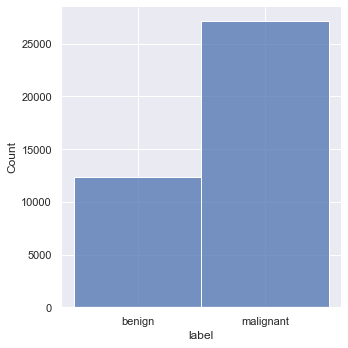

In [16]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

In [1]:
sns.countplot(x=data['label'], data=data)

NameError: name 'sns' is not defined

In [12]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(3000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [13]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.3)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [14]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 23481
Total validation images: 10064
Total testing images: 6000


In [15]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [16]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-007.png,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-009.png,train


# Visualizing Train, Validation and Test Splits

<AxesSubplot:xlabel='label', ylabel='count'>

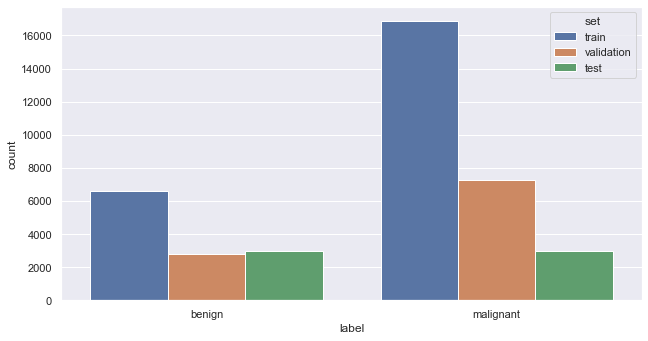

In [17]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

# Unsampling data


In [18]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [19]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-29960CD-200-014.png,train
1,4,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-16184-40-002.png,train
2,1,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-21998AB-100-050.png,train
3,1,400,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-21998AB-400-027.png,train
4,5,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-19854C-200-014.png,train


# Deep Learning Model

In [20]:
model_handle_map = {"efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                   "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4", 
                   "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4"}
model_image_size = {"efficientnetv2-b0": 224, 
                   "inception_v3": 299, 
                   "inception_resnet_v2": 299}

In [21]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5), 
                          A.Rotate(p = 0.5, limit = 15), 
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), 
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=IMG_SIZE, width=IMG_SIZE, 
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))
                           
                          ])
    
    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [IMG_SIZE, IMG_SIZE]) / 255
    
    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 5, row = 5, size=(30, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def view_model_predictions():
    plt.figure(figsize = (30, 8))
    plt.rcParams.update({'font.size': 10})
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_image[i].numpy().shape)
        plt.imshow(test_image[i].numpy())
        plt.title(predicted_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None

# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
    plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
    plt.legend()
    
    return None

# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# function for building a NN
def make_nn_model(image_size):
    print('Making our deep cnn model.....')
    cnn_model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base'),
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, name='dropout'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        # layers.Dropout(0.4, name='dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=model_name)
    
    cnn_model.build((None, image_size, image_size, 3))
    cnn_model.summary()
    print('model built!')
    return cnn_model

In [22]:
# defining model configuration parameters
model_name = "efficientnetv2-b0"
# model_name = "inception_v3"
# model_name = "inception_resnet_v2"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 32
EPOCHS = 10
sample_size = len(train_images)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size of model: {IMG_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size of model: 224


In [23]:
IMG_SIZE

224

In [24]:
(image_dir + train_images.path)[0]

'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-014.png'

In [25]:
# loading the train & validation dataets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + train_images.path, 
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + validation_images.path, 
                                                validation_images.label_int))

In [26]:
load_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
train_images.path[5]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-018.png'

Time Taken: 1.613 seconds


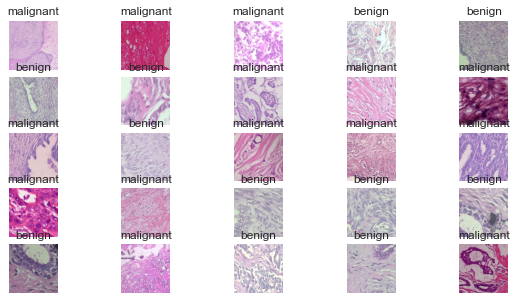

In [29]:
start = time.time()
view_image(train_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 1.793 seconds


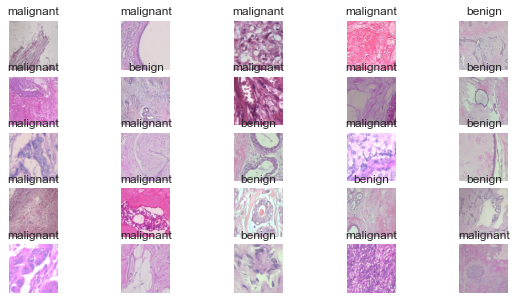

In [30]:
start = time.time()
view_image(val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

# Deep Learning Model Training Using K Fold Cross Validation


In [ ]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels
get_labels_from_tfdataset(train_dataset)

In [ ]:
print('Size of Image being used: %d' % (IMG_SIZE))

In [ ]:
# starting a new sesion for TF
image_size = 224
tf.keras.backend.clear_session()
model_nn = make_nn_model(IMG_SIZE)

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

# compiling the model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# fit the model
train_history = model_nn.fit(train_dataset, epochs=10, batch_size=BATCH_SIZE, verbose=1, 
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)

In [ ]:
# visualize model performance
history = train_history.history
model_hist(history)

In [34]:
model_performance = model_nn.evaluate(val_dataset)

149/315 [=============>................] - ETA: 2:07 - loss: 0.3583 - accuracy: 0.8658 - Precision: 0.7604 - Recall: 0.7570

KeyboardInterrupt: 

In [ ]:
print('Net loss on validation data: %.3f' % model_performance[0])
print('Net accuracy on validation data: %.3f' % model_performance[1])
print('Net precision on validation data: %.3f' % model_performance[2])
print('Net recall on validation data: %.3f' % model_performance[3])

# Evaluating Test Data

In [ ]:
# making samples of test data
test_images = test_images.sample(frac=1).reset_index(drop=True)
test_data = tf.data.Dataset.from_tensor_slices(image_dir + test_images.path)
test_data = test_data.map(decode_test_img, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_data

In [ ]:
print('Total Test Images: %d' % len(test_images))

In [ ]:
test_index = test_images.label_int.values
test_labels = test_images.label.values
test_index, test_labels

In [ ]:
test_image = next(iter(test_data))

In [ ]:
# making predictions
test_predictions = model_nn.predict(test_data)
predicted_index = np.round(test_predictions)

In [ ]:
# checking predictions made by neural network
predicted_index[:6]

In [ ]:
predicted_index = np.round(test_predictions).astype(int)
predicted_label = np.array(class_names)[predicted_index]
predicted_label[:8]

In [ ]:
prediction_data = pd.DataFrame({'filename':test_images.filename.values,'actual':test_images.label.values, 
                              'prediction': np.squeeze(predicted_label),'path':test_images.path.values,})

In [ ]:
# see model predictions
prediction_data[['actual', 'prediction']].head(15)